# Capstone Project: Exploring Rome: where to open your restaurant

Installs and imports relevante packages.

In [ ]:
!pip install geocoder
!pip install geopy

import pandas as pd
import geocoder
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

Retrieves the coordinates of Rome.

In [2]:
address = 'Rome, IT'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_center = location.latitude
longitude_center = location.longitude
print('The geograpical coordinate of Rome are {}, {}.'.format(latitude_center, longitude_center))

The geograpical coordinate of Rome are 41.8933203, 12.4829321.


Defines a functions which returns the distance (in kilometers) between two points given their latitude and longitude.

In [3]:
def distance (lat1, long1, lat2, long2):
    
    R = 6373.0

    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    dlong = long2 - long1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlong / 2)**2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist = R * c
    return(dist)

Imports a .xlsx file where the names of neighborhoods of Rome, together with their coordinates, population and area are stored. Then, adds a new column containing the distance of each neighbourhood from the city center.

In [4]:
df = pd.read_excel('Quartieri_Roma.xlsx')
df.drop(columns = ['Unnamed: 0', 'Coordinates'], inplace = True)

df[['Distance']] = df[['Name']]
df[['Distance']] = df.apply( lambda row: distance(row['Latitude'],row['Longitude'],latitude_center,longitude_center), axis = 1)

df.head()

,Name,Area,Population,Latitude,Longitude,Distance
0,Flaminio,1.1877,12155,41.92633,12.468281,3.866773
1,Parioli,4.7506,13749,41.93473,12.492440,4.672743
2,Pinciano,3.5662,20854,41.92177,12.486754,3.180231
3,Salario,0.4668,8301,41.91507,12.500687,2.830723
4,Nomentano,3.2611,39245,41.91354,12.515327,3.500043


Displays each neighborhood on the map.

In [5]:
map_roma = folium.Map(location=[latitude_center, longitude_center], zoom_start=10.2)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma

Defines a function that makes an API call to Foursquares in order to get venues within a certain radius of some given coordinates.

In [6]:
CLIENT_ID = 'ZNVUVEZAZD4JCOTB432V1DQOJKNMBQIHH04PB4BORXZGGUDQ' 
CLIENT_SECRET = 'N0XRGWCAJJGIVQFZJNS35J4JU4TJEWNDGTQDIG0IB4GSZWJM' 
VERSION = '20180605'

In [7]:
def getNearbyVenues(names, latitudes, longitudes, distance, population, radius=500):
    
    venues_list=[]
    for name, lat, lng, dist, pop in zip(names, latitudes, longitudes, distance, population):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            dist,
            pop,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Distance',
                  'Population',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

After the API call, creates a dataframe with the retrieved data added.

In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 800 # define radius

neighborhood_latitude = 0
neighborhood_longitude = 0

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

roma_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   distance = df['Distance'],
                                   population = df['Population']
                                  )

Flaminio
Parioli
Pinciano
Salario
Nomentano
Tiburtino
Prenestino-Labicano
Tuscolano
Appio-Latino
Ostiense
Portuense
Gianicolense
Aurelio
Trionfale
Della Vittoria
Monte Sacro
Trieste
Tor di Quinto
Prenestino-Centocelle
Ardeatino
Pietralata
Collatino
Alessandrino
Don Bosco
Appio Claudio
Appio-Pignatelli
Primavalle
Monte Sacro Alto
Ponte Mammolo
San Basilio
Giuliano-Dalmata
Europa
Lido di Ostia Ponente
Lido di Ostia Levante
Lido di Castel Fusano


In [9]:
roma_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Distance,Population,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Flaminio,41.92633,12.468281,3.866773,12155,20MQ Design e Caffè,41.925191,12.470467,Café
1,Flaminio,41.92633,12.468281,3.866773,12155,MAXXI Museo Nazionale delle Arti del XXI Secolo,41.928455,12.466840,Art Museum
2,Flaminio,41.92633,12.468281,3.866773,12155,Tiepolo,41.924321,12.469223,Diner
3,Flaminio,41.92633,12.468281,3.866773,12155,Hotel Butterfly,41.927151,12.467478,Restaurant
4,Flaminio,41.92633,12.468281,3.866773,12155,Villa Flaminia Centro Sportivo,41.925956,12.468924,Pool


Renames all the categories with "Restaurant" in their name with simply "Restaurant" and all categories with "Café" in their name with "Bar".

In [10]:
roma_venues.loc[roma_venues['Venue Category'].str.contains('Restaurant'), 'Venue Category'] = 'Restaurant'
roma_venues.loc[roma_venues['Venue Category'].str.contains('Café'), 'Venue Category'] = 'Bar'

roma_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Distance,Population,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Flaminio,41.92633,12.468281,3.866773,12155,20MQ Design e Caffè,41.925191,12.470467,Bar
1,Flaminio,41.92633,12.468281,3.866773,12155,MAXXI Museo Nazionale delle Arti del XXI Secolo,41.928455,12.466840,Art Museum
2,Flaminio,41.92633,12.468281,3.866773,12155,Tiepolo,41.924321,12.469223,Diner
3,Flaminio,41.92633,12.468281,3.866773,12155,Hotel Butterfly,41.927151,12.467478,Restaurant
4,Flaminio,41.92633,12.468281,3.866773,12155,Villa Flaminia Centro Sportivo,41.925956,12.468924,Pool


Performs a one-hot encoding in order to transform the categorical "Venue Category" values into numerical ones.

In [11]:
# one hot encoding
roma_onehot = pd.get_dummies(roma_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
roma_onehot[['Distance','Population','Neighborhood']] = roma_venues[['Distance','Population','Neighborhood']] 
# move neighborhood column to the first column
fixed_columns = [roma_onehot.columns[-1]] + list(roma_onehot.columns[:-1])
roma_onehot = roma_onehot[fixed_columns]

roma_onehot.head()

,Neighborhood,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Stadium,Beach,Bed & Breakfast,...,Train Station,Trattoria/Osteria,University,Video Game Store,Video Store,Warehouse Store,Wine Bar,Winery,Distance,Population
0,Flaminio,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.866773,12155
1,Flaminio,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.866773,12155
2,Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.866773,12155
3,Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.866773,12155
4,Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.866773,12155


Normalizes the "Population" and "Distance" columns and groups by Neighborhood's name, averaging among the categories.

In [12]:
roma_onehot['Distance'] = (roma_onehot['Distance']-roma_onehot['Distance'].min())/(roma_onehot['Distance'].max()-roma_onehot['Distance'].min())
roma_onehot['Distance'] = (1 - roma_onehot['Distance'])*1.5

total_population = df.groupby('Name')['Population'].sum().sum()

roma_onehot['Population'] = roma_onehot['Population']/total_population

roma_grouped = roma_onehot.groupby('Neighborhood').mean().reset_index()

roma_grouped.head()

,Neighborhood,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Stadium,Beach,Bed & Breakfast,...,Train Station,Trattoria/Osteria,University,Video Game Store,Video Store,Warehouse Store,Wine Bar,Winery,Distance,Population
0,Alessandrino,0.0,0.0,0.2,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.123867,0.025431
1,Appio Claudio,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.127428,0.019008
2,Appio-Latino,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,1.459780,0.039813
3,Appio-Pignatelli,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.237648,0.004569
4,Ardeatino,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.382440,0.044726


Defines a function which finds the most common venues of each neighborhood.

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Finds the top 10 most common venues for each neighborhood and displays them into a dataframe.

In [14]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Relevant Feature'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Relevant Feature'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = roma_grouped['Neighborhood']

for ind in np.arange(roma_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(roma_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Relevant Feature,2nd Most Relevant Feature,3rd Most Relevant Feature,4th Most Relevant Feature,5th Most Relevant Feature,6th Most Relevant Feature,7th Most Relevant Feature,8th Most Relevant Feature,9th Most Relevant Feature,10th Most Relevant Feature
0,Alessandrino,Distance,Restaurant,Park,Athletics & Sports,Gym / Fitness Center,Population,Donut Shop,Electronics Store,Farmers Market,Flea Market
1,Appio Claudio,Distance,BBQ Joint,Football Stadium,Tennis Court,Population,Bakery,Donut Shop,Farmers Market,Flea Market,Food
2,Appio-Latino,Distance,Restaurant,Trattoria/Osteria,Gym,Gastropub,Pizza Place,Pub,Supermarket,Hotel,Population
3,Appio-Pignatelli,Distance,Garden,IT Services,Population,BBQ Joint,General Entertainment,Farmers Market,Flea Market,Food,Food Court
4,Ardeatino,Distance,Restaurant,Bar,Supermarket,Bistro,Hotel,Gym Pool,Pizza Place,Plaza,Diner


Performs a K-Mean algorithm to cluster the neighborhoods into 5 clusters, based on venues, distance from the center and population.

In [15]:
kclusters = 5

roma_grouped_clustering = roma_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(roma_grouped_clustering)

kmeans.labels_[0:10] 

array([0, 0, 3, 0, 3, 3, 0, 3, 0, 0], dtype=int32)

Creates a new column into the dataframe which displays the cluster label of each neighborhood.

In [16]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

roma_merged = df

roma_merged = roma_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

roma_merged.dropna(axis = 0, inplace = True)
roma_merged['Cluster Labels'] = roma_merged['Cluster Labels'].astype('int32')

roma_merged

,Name,Area,Population,Latitude,Longitude,Distance,Cluster Labels,1st Most Relevant Feature,2nd Most Relevant Feature,3rd Most Relevant Feature,4th Most Relevant Feature,5th Most Relevant Feature,6th Most Relevant Feature,7th Most Relevant Feature,8th Most Relevant Feature,9th Most Relevant Feature,10th Most Relevant Feature
0,Flaminio,1.1877,12155,41.92633,12.468281,3.866773,3,Distance,Restaurant,Bar,Hotel,Bistro,Pool,Diner,Soccer Stadium,Paper / Office Supplies Store,Sporting Goods Shop
1,Parioli,4.7506,13749,41.93473,12.492440,4.672743,3,Distance,Hotel,Tennis Court,Gym / Fitness Center,Pool,General Entertainment,Bar,Track Stadium,Population,Gym
2,Pinciano,3.5662,20854,41.92177,12.486754,3.180231,3,Distance,Restaurant,Hotel,Bar,Plaza,Multiplex,Electronics Store,University,Science Museum,Diner
3,Salario,0.4668,8301,41.91507,12.500687,2.830723,3,Distance,Restaurant,Bar,Pizza Place,Dessert Shop,Pub,Ice Cream Shop,Juice Bar,Steakhouse,Plaza
4,Nomentano,3.2611,39245,41.91354,12.515327,3.500043,3,Distance,Restaurant,Hotel,Art Museum,Ice Cream Shop,Plaza,Theater,Winery,Bar,Trattoria/Osteria
5,Tiburtino,3.7123,22563,41.90661,12.516121,3.120089,3,Distance,Restaurant,Bar,Pizza Place,Hotel,Bistro,Pub,Bed & Breakfast,Plaza,Ice Cream Shop
6,Prenestino-Labicano,4.7089,72661,41.88834,12.546886,5.324377,3,Distance,Restaurant,Soccer Field,Market,Gym,Grocery Store,Record Shop,Population,Beach,Bed & Breakfast
7,Tuscolano,7.1572,103446,41.87360,12.539699,5.187496,3,Distance,Bar,Restaurant,Art Gallery,Sandwich Place,Gym,Martial Arts Dojo,Park,Pool,Population
8,Appio-Latino,5.8491,59325,41.87200,12.512505,3.409012,3,Distance,Restaurant,Trattoria/Osteria,Gym,Gastropub,Pizza Place,Pub,Supermarket,Hotel,Population
9,Ostiense,7.1231,62339,41.86018,12.480774,3.690521,3,Distance,Restaurant,Bar,Nightclub,Pub,Beer Bar,Ice Cream Shop,Park,Cocktail Bar,Clothing Store


Displays the clusters on the city map.

In [17]:
# create map
map_clusters = folium.Map(location=[latitude_center, longitude_center], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(roma_merged['Latitude'], roma_merged['Longitude'], roma_merged['Name'], roma_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Eliminates Ostia (i.e. clusters 1 and 2) from the dataframe and creates a new dataframe with only cluster labels and most common venues.

In [18]:
roma_city = roma_merged.head(30)
roma_city = roma_city[['Name', 'Cluster Labels','2nd Most Relevant Feature']]
roma_city.rename({'2nd Most Relevant Feature': 'Most Common Venue'}, axis = 1, inplace = True)
roma_city.reset_index(drop = True, inplace = True)
roma_city.head()

,Name,Cluster Labels,Most Common Venue
0,Flaminio,3,Restaurant
1,Parioli,3,Hotel
2,Pinciano,3,Restaurant
3,Salario,3,Restaurant
4,Nomentano,3,Restaurant


Counts how many times the most common venue of each neighborhood appears in said neighborhood.

In [19]:
quartieri = roma_city['Name'].values
count = []

for quartiere in quartieri:
    index = roma_city.index[roma_city['Name'] == quartiere][0]
    query1 = roma_venues['Neighborhood'] == quartiere
    
    a = roma_venues[query1]
    query2 = a['Venue Category'] == roma_city.iloc[index]['Most Common Venue']

    count.append(a[query2]['Venue Category'].count())

venue_count = pd.DataFrame(count)
roma_city['Count'] = venue_count[0]

roma_city.head()

,Name,Cluster Labels,Most Common Venue,Count
0,Flaminio,3,Restaurant,8
1,Parioli,3,Hotel,2
2,Pinciano,3,Restaurant,6
3,Salario,3,Restaurant,23
4,Nomentano,3,Restaurant,8


Plots the most common venue count for cluster 3.

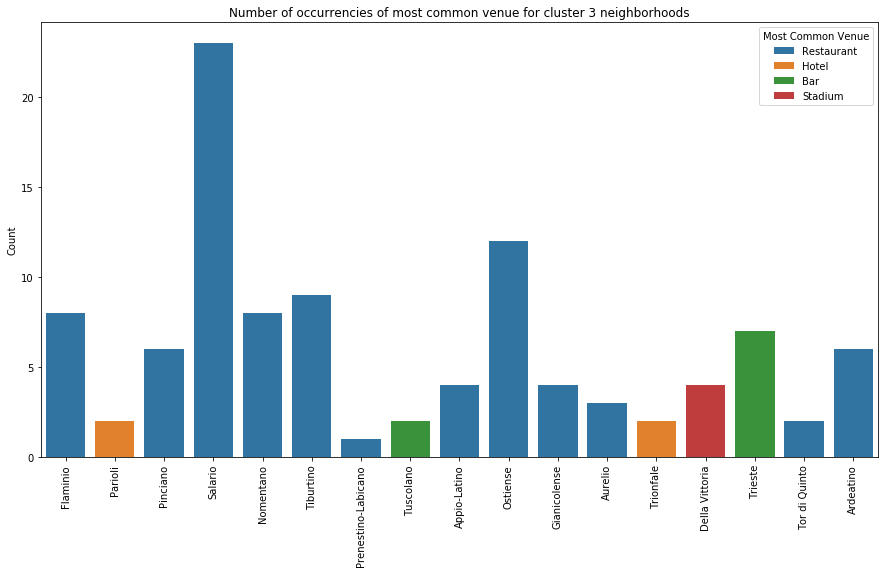

In [20]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.catplot(x="Name", y="Count", hue = "Most Common Venue", kind="bar", data=roma_city[roma_city['Cluster Labels'] == 3], ax = ax, dodge=False)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_title('Number of occurrencies of most common venue for cluster 3 neighborhoods')
ax.set_xlabel('')
    
plt.close(2)

Plots the most common venue count for cluster 0.

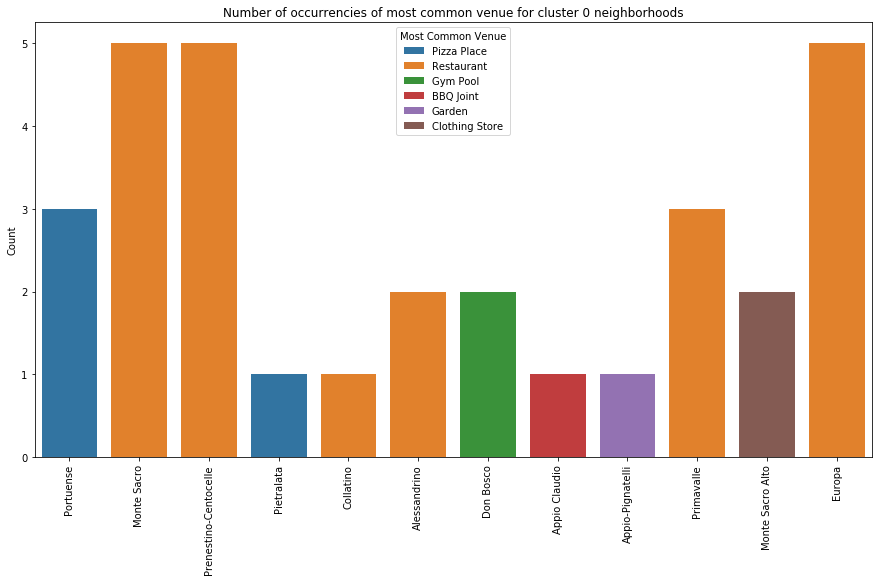

In [21]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.catplot(x="Name", y="Count", hue = "Most Common Venue", kind="bar", \
                   data=roma_city[roma_city['Cluster Labels'] == 0], ax = ax, dodge=False)

ax.set_title('Number of occurrencies of most common venue for cluster 0 neighborhoods')
ax.set_xlabel('')

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.close(2)

Checks which neighborhood, between Parioli, Trionfale or Della Vittoria is closer to the center.

In [34]:
in_parioli = df.index[df['Name'] == 'Parioli'][0]
in_trionfale = df.index[df['Name'] == 'Trionfale'][0]
in_vittoria = df.index[df['Name'] == 'Della Vittoria'][0]

print('Parioli:',df.iloc[in_parioli]['Distance'])
print('Trionfale:',df.iloc[in_trionfale]['Distance'])
print('Della Vittoria:',df.iloc[in_vittoria]['Distance'])

Parioli: 4.672742533881201
Trionfale: 5.738791500932706
Della Vittoria: 4.681801342247521
